# Тема "Классификация текста"

Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили 

1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново

2. Проверьте повысилось ли качество на стандартных подходах при лемматизации/и без неё

3. Удалите/(замените на тег) из текстов сущности(имена, локации, что-то ещё). Запустите классификатор и модельки на сеточках

4. Сделайте выводы


# Классификация текстов

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [1]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


In [2]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

In [3]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import re

In [4]:
def word_preprocessing(word):
    
    # удаляем пунктуацию
    word = re.sub(r'[^\w\s]', '', word)
    
    # удаляем спец. символы 
    word = re.sub(r'[^a-zA-Z0-9]', '', word)
    
    # замена чисел
    word = re.sub(r'[^a-zA-Z]', '', word)
    
    # приводим в нижний регистр
    word = word.lower()
           
    return word

In [6]:
good_words = Counter(" ".join(test_df.loc[test_df['is_positive'] == 1]['review']).split()).most_common(1000)
good_words = [w[0] for w in good_words if w[0] not in stopwords.words('english')]

bad_words = Counter(" ".join(test_df.loc[test_df['is_positive'] == 0]['review']).split()).most_common(1000)
bad_words = [w[0] for w in bad_words if w[0] not in stopwords.words('english')]

good_words_final = [w for w in good_words if w not in bad_words]
bad_words_final = [w for w in bad_words if w not in good_words]

min_len = min(len(good_words_final), len(bad_words_final))
good_words_final = good_words_final[:min_len]
bad_words_final = bad_words_final[:min_len]
good_words_final = [word_preprocessing(w) for w in good_words_final]
bad_words_final = [word_preprocessing(w) for w in bad_words_final]

print('Хорошие слова')
print(good_words_final)
print(100*'-')
print('Плохие слова')
print(bad_words_final)

Хорошие слова
['wonderful', 'favorite', 'brilliant', 'highly', 'amazing', 'strong', 'greatest', 'simple', 'heart', 'supporting', 'although', 'musical', 'romantic', 'hilarious', 'life', 'experience', 'view', 'documentary', 'emotional', 'personal', 'enjoyable', 'keeps', 'too', 'happy', 'famous', 'surprised', 'reality', 'power', 'easy', 'meets', 'unique', 'brings', 'attention', 'theme', 'powerful', 'moving', 'art', 'soundtrack', 'cinematography', 'memorable', 'peter', 'fantastic', 'episodes', 'difficult', 'country', 'perfectly', 'events', 'great', 'television', 'husband', 'tale', 'leads', 'realistic', 'songs', 'elements', 'begins', 'light', 'war', 'release', 'deserves', 'show', 'roles', 'watch', 'interested', 'visual', 'portrayal', 'open', 'features', 'political', 'superb', 'times', 'her', 'age', 'great', 'follows', 'deep', 'oscar', 'older', 'also', 'miss', 'appreciate', 'richard', 'caught', 'message', 'beauty', 'german', 'form', 'portrayed', 'parents', 'eventually', 'you', 'tom', 'brothe

In [8]:
#Отфильтруем вручную слова
positive_words = ['wonderful', 'favorite', 'brilliant', 'highly', 'amazing', 'strong', 'greatest', 'heart', 'romantic',
                  'happy', 'surprised', 'unique', 'soundtrack', 'cinematography', 'memorable', 'fantastic', 'perfectly',
                  'great', 'realistic', 'interested', 'visual', 'oscar', 'beautifully', 'atmosphere', 'best',
                  'believable', 'talented'][:20]
negative_words = ['worst', 'waste', 'stupid', 'terrible', 'boring', 'awful', 'worse', 'horrible', 'bad', 'hour', 'cheap',
                  'poorly', 'annoying', 'silly', 'wasted', 'hours', 'spent', 'crap', 'flick', 'basically', 'fails', 'none',
                  'apparently', 'dialog', 'badly', 'hell', 'lame', 'unless', 'predictable', 'weak', 'forced', 'attempts',
                  'plain', 'cheesy', 'effort', 'gore', 'disappointed', 'average', 'barely', 'dumb', 'unfortunately',
                  'bother', 'biggest', 'filmmakers', 'awful', 'gay', 'seriously', 'spend', 'storyline', 'expected', 'excuse',
                  'quickly', 'pathetic', 'waiting', 'sitting', 'bored', 'fake'][:20]

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    print('Ура')

Test accuracy = 71.71%
Ура


In [9]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(100*'-')
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

In [10]:
train_df['review'] = train_df['review'].apply(lambda text: pattern.subn(' ', text)[0])
test_df['review'] = test_df['review'].apply(lambda text: pattern.subn(' ', text)[0])

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Попробуем кого-нибудь таки сконвертировать

In [17]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 206 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Запустим теперь её на реальных данных.

In [19]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [20]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.38%


In [21]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.888,refreshing
+1.788,wonderfully
+1.720,funniest
+1.670,surprisingly
+1.648,rare
+1.438,superb
+1.392,excellent
+1.378,incredible
+1.325,perfect
+1.322,delightful


Посмотрим на конкретные примеры его работы:

In [22]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [23]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [24]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.28%


In [26]:
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+7.553,great
+6.153,excellent
+5.121,best
+4.814,perfect
+4.654,wonderful
+4.132,amazing
+4.000,well
+3.837,loved
+3.771,favorite
+3.769,fun


In [27]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [28]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Пример неправильной работы:

In [29]:
preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.


In [30]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.64%


**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [34]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.76%
Wall time: 1min 20s


In [35]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(1, 4))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 86.89%
Wall time: 2min 15s


In [36]:
%%time
vectorizer = TfidfVectorizer(ngram_range=(2, 4))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 85.88%
Wall time: 1min 56s


Наблюдение: какой-то сомнительный получается эффект

### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [37]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.86%


In [38]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [39]:
preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [41]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [82]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

Dreamgirls Dreamgirls B GPE
, , O 
despite despite O 
its its O 
fistful fistful O 
of of O 
Tony Tony B PERSON
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
Broadway Broadway B FAC
, , O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
. . O 
However however O 
, , O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
- - O 
screen screen O 
. . O 
Unfortunately unfortunately O 
, , O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faith

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [84]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

print(stemmer.stem('become'))
print(stemmer.stem('becomes'))
print(stemmer.stem('became'))

becom
becom
becam


**Задание** Попробуйте вместо лемм классифицировать основы.

In [86]:
this_train_df = train_df.copy()
this_test_df = test_df.copy()

this_train_df['review_stemm'] = this_train_df.apply(lambda row: stemmer.stem(row['review']), axis = 1)
this_test_df['review_stemm'] = this_test_df.apply(lambda row: stemmer.stem(row['review']), axis = 1)

In [87]:
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(this_train_df['review_stemm'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.29%


### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [88]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

## Включаем дип лёрнинг

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [89]:
train_df['review']

0        Dreamgirls, despite its fistful of Tony wins i...
1        This show comes up with interesting locations ...
2        I simply love this movie. I also love the Ramo...
3        Spoilers ahead if you want to call them that.....
4        My all-time favorite movie! I have seen many m...
                               ...                        
24995    I am a big fan of the movie, but not for the u...
24996    I'm not going to bother with a plot synopsis s...
24997    This movie . . . I don't know. Why they would ...
24998    Saw this film on DVD yesterday and was gob-sma...
24999    This was a disappointment - none of the nuance...
Name: review, Length: 25000, dtype: object

<BarContainer object of 231 artists>

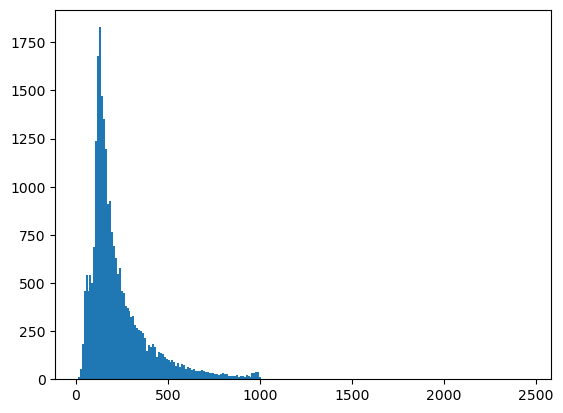

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [91]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 26783


**Задание** Сконвертируйте данные

In [92]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [93]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [94]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [129]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1000, 64)          1714112   
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,714,883
Trainable params: 1,714,883
Non-trainable params: 0
____________________________________________

In [130]:
hist = model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive), verbose=0)

**Задание** Подсчитайте качество модели на тесте

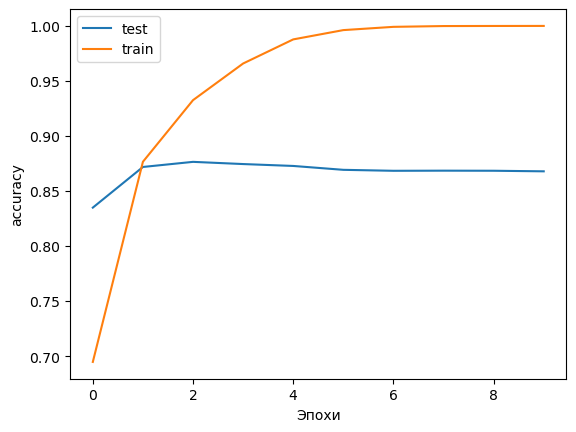

In [131]:
plt.plot(hist.history['val_accuracy'], label='test')
plt.plot(hist.history['accuracy'], label='train')
plt.xlabel('Эпохи')
plt.ylabel('accuracy')
plt.legend()
plt.show()